In [1]:
import numpy as np               # For linear algebra
import pandas as pd              # For data manipulation
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns            
import missingno as mn           # For visualizing missing values.
from scipy import stats          # For statistics

In [2]:
df_train = pd.read_csv('train_after_mvi.csv')

In [3]:
df_test = pd.read_csv('test_after_mvi.csv')

In [4]:
df_train.dtypes

Country                             object
V1                                 float64
V2                                 float64
V3                                 float64
V4                                 float64
V5                                 float64
V6                                 float64
V7                                 float64
V8                                 float64
V9                                 float64
V10                                float64
V11                                  int64
Dependent Variable (Bankruptcy)      int64
dtype: object

In [5]:
df_train['Country'] =df_train['Country'].astype('category')
df_train['V11'] =df_train['V11'].astype('category')

In [6]:
df_test['Country'] =df_test['Country'].astype('category')
df_test['V11'] =df_test['V11'].astype('category')

In [7]:
#Dropping Countries column as our model is based on financial factors related to the company. 
df_train = df_train.drop(columns=['Country'],axis=1)
df_test = df_test.drop(columns=['Country'],axis=1)

In [8]:
##Get_Dummies : Convert categorical variable into dummy/indicator variables
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [9]:
#Renaming the Dependent variable bankruptcy column
df_train.rename(index=str,columns={'Dependent Variable (Bankruptcy)':'Bankrupt'},inplace=True)
df_test.rename(index=str,columns={'Dependent Variable (Bankruptcy)':'Bankrupt'},inplace=True)

In [10]:
#Dropping Bankrupt from 
X_test = df_test.drop(columns = ['Bankrupt'], axis = 1)
y_test = df_test['Bankrupt']

In [11]:
#Dividing X_train and y_train variables
X_train = df_train.drop(columns = ['Bankrupt'], axis = 1) 
y_train = df_train['Bankrupt'] 

In [12]:
## Running Model 
## Decision Tree Model 
seed =43 ## for reproducibility
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = seed)
dt.fit(X_train, y_train)
train_accuracy = dt.score(X_train, y_train)
train_accuracy = np.round(train_accuracy*100, 2)

In [13]:
print(train_accuracy)

100.0


In [14]:
y_pred = dt.predict(X_test)

In [15]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(dt.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


In [16]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[31, 17],
       [ 9, 37]], dtype=int64)

In [17]:
y_train_pred = dt.predict(X_train)

In [18]:
cnf_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
cnf_matrix_train

array([[186,   0],
       [  0, 188]], dtype=int64)

Tuning Hyperparameters
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes

In [19]:
'''For DT, the following hyperparameters are usually tunned.'''
dt_params = {'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
             'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             'random_state':[seed]}

In [20]:
from sklearn.model_selection import GridSearchCV
global best_params, best_score
# Construct grid search object with 10 fold cross validation.
grid = GridSearchCV(dt, dt_params, verbose = 0, cv = 10, scoring = 'accuracy', n_jobs = -1)
grid.fit(X_train, y_train)
best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)

In [21]:
print('DT Best Score:', best_score)
print('And Best Parameters:', best_params)

DT Best Score: 85.56
And Best Parameters: {'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 43}


In [22]:
dt_optimized  = DecisionTreeClassifier(**best_params)

In [23]:
dt_optimized.fit(X_train, y_train)
train_accuracy_opt = dt_optimized.score(X_train, y_train)
train_accuracy_opt = np.round(train_accuracy_opt*100, 2)

In [24]:
train_accuracy_opt

94.12

In [25]:
y_pred_opt = dt_optimized.predict(X_test)

In [26]:
cnf_matrix_opt = metrics.confusion_matrix(y_test, y_pred_opt)
cnf_matrix_opt

array([[37, 11],
       [ 9, 37]], dtype=int64)

In [27]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(dt_optimized.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [28]:
y_train_pred_opt = dt_optimized.predict(X_train)

In [29]:
cnf_matrix_train_opt = metrics.confusion_matrix(y_train, y_train_pred_opt)
cnf_matrix_train_opt

array([[179,   7],
       [ 15, 173]], dtype=int64)

In [30]:
f'''Function to plot ROC curve with AUC score.'''
def plot_roc_and_auc_score(model, title):
    from sklearn.metrics import roc_curve, roc_auc_score
    probablity = model.predict_proba(X_train)[:, 1]
    plt.figure(figsize = (18, 5))
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, probablity)
    auc_score = roc_auc_score(y_train, probablity)
    plt.plot(false_positive_rate, true_positive_rate, label = "ROC CURVE, AREA = "+ str(auc_score))
    plt.plot([0, 1], [0, 1], 'red', lw = 3.7)
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.axis([0, 1, 0, 1])
    plt.legend(loc = 4)
    plt.title(title)
    plt.show()

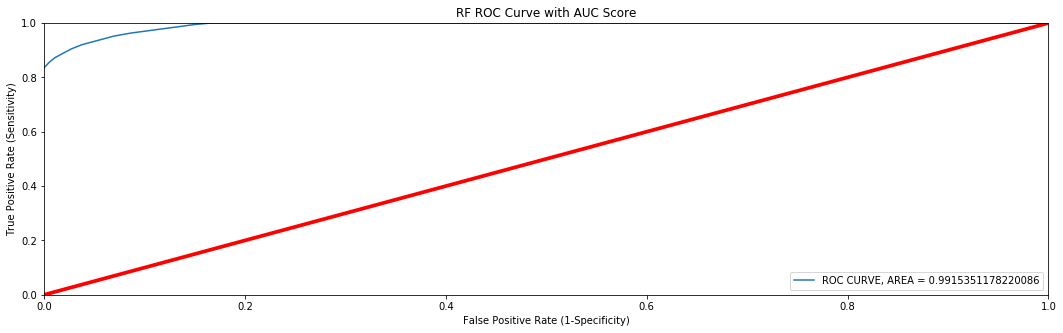

In [31]:
plot_roc_and_auc_score(dt_optimized, title = 'RF ROC Curve with AUC Score')

In [32]:
f'''Function to plot ROC curve with AUC score.'''
def plot_roc_and_auc_score_test(model, title):
    from sklearn.metrics import roc_curve, roc_auc_score
    probablity = model.predict_proba(X_test)[:, 1]
    plt.figure(figsize = (18, 5))
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, probablity)
    auc_score = roc_auc_score(y_test, probablity)
    plt.plot(false_positive_rate, true_positive_rate, label = "ROC CURVE, AREA = "+ str(auc_score))
    plt.plot([0, 1], [0, 1], 'red', lw = 3.7)
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.axis([0, 1, 0, 1])
    plt.legend(loc = 4)
    plt.title(title)
    plt.show()

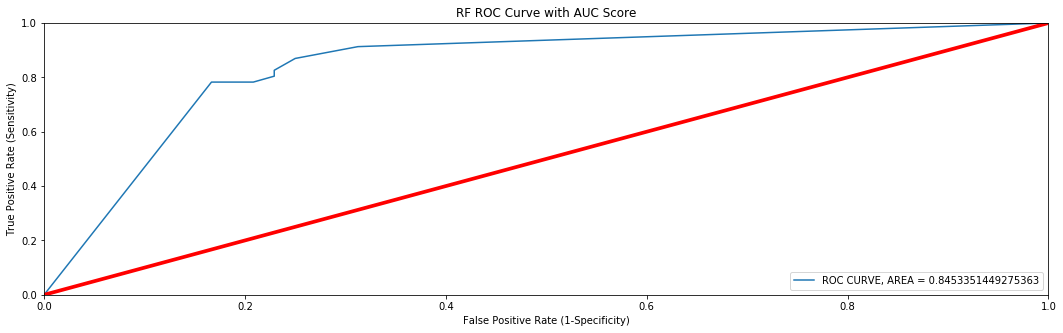

In [33]:
plot_roc_and_auc_score_test(dt_optimized, title = 'RF ROC Curve with AUC Score')

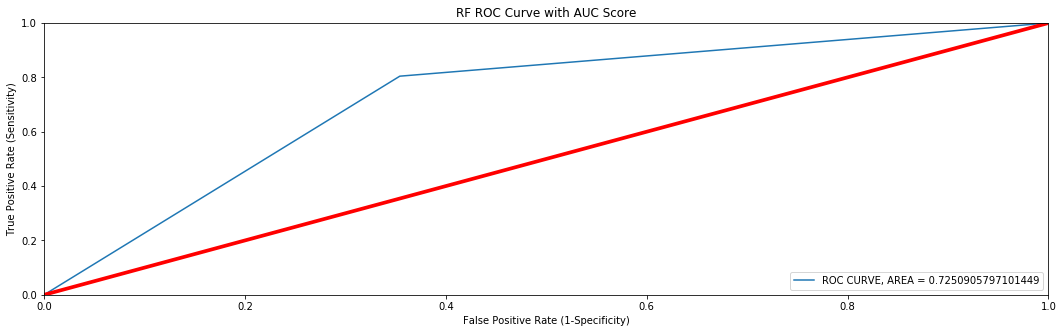

In [38]:
plot_roc_and_auc_score_test(dt, title = 'RF ROC Curve with AUC Score')

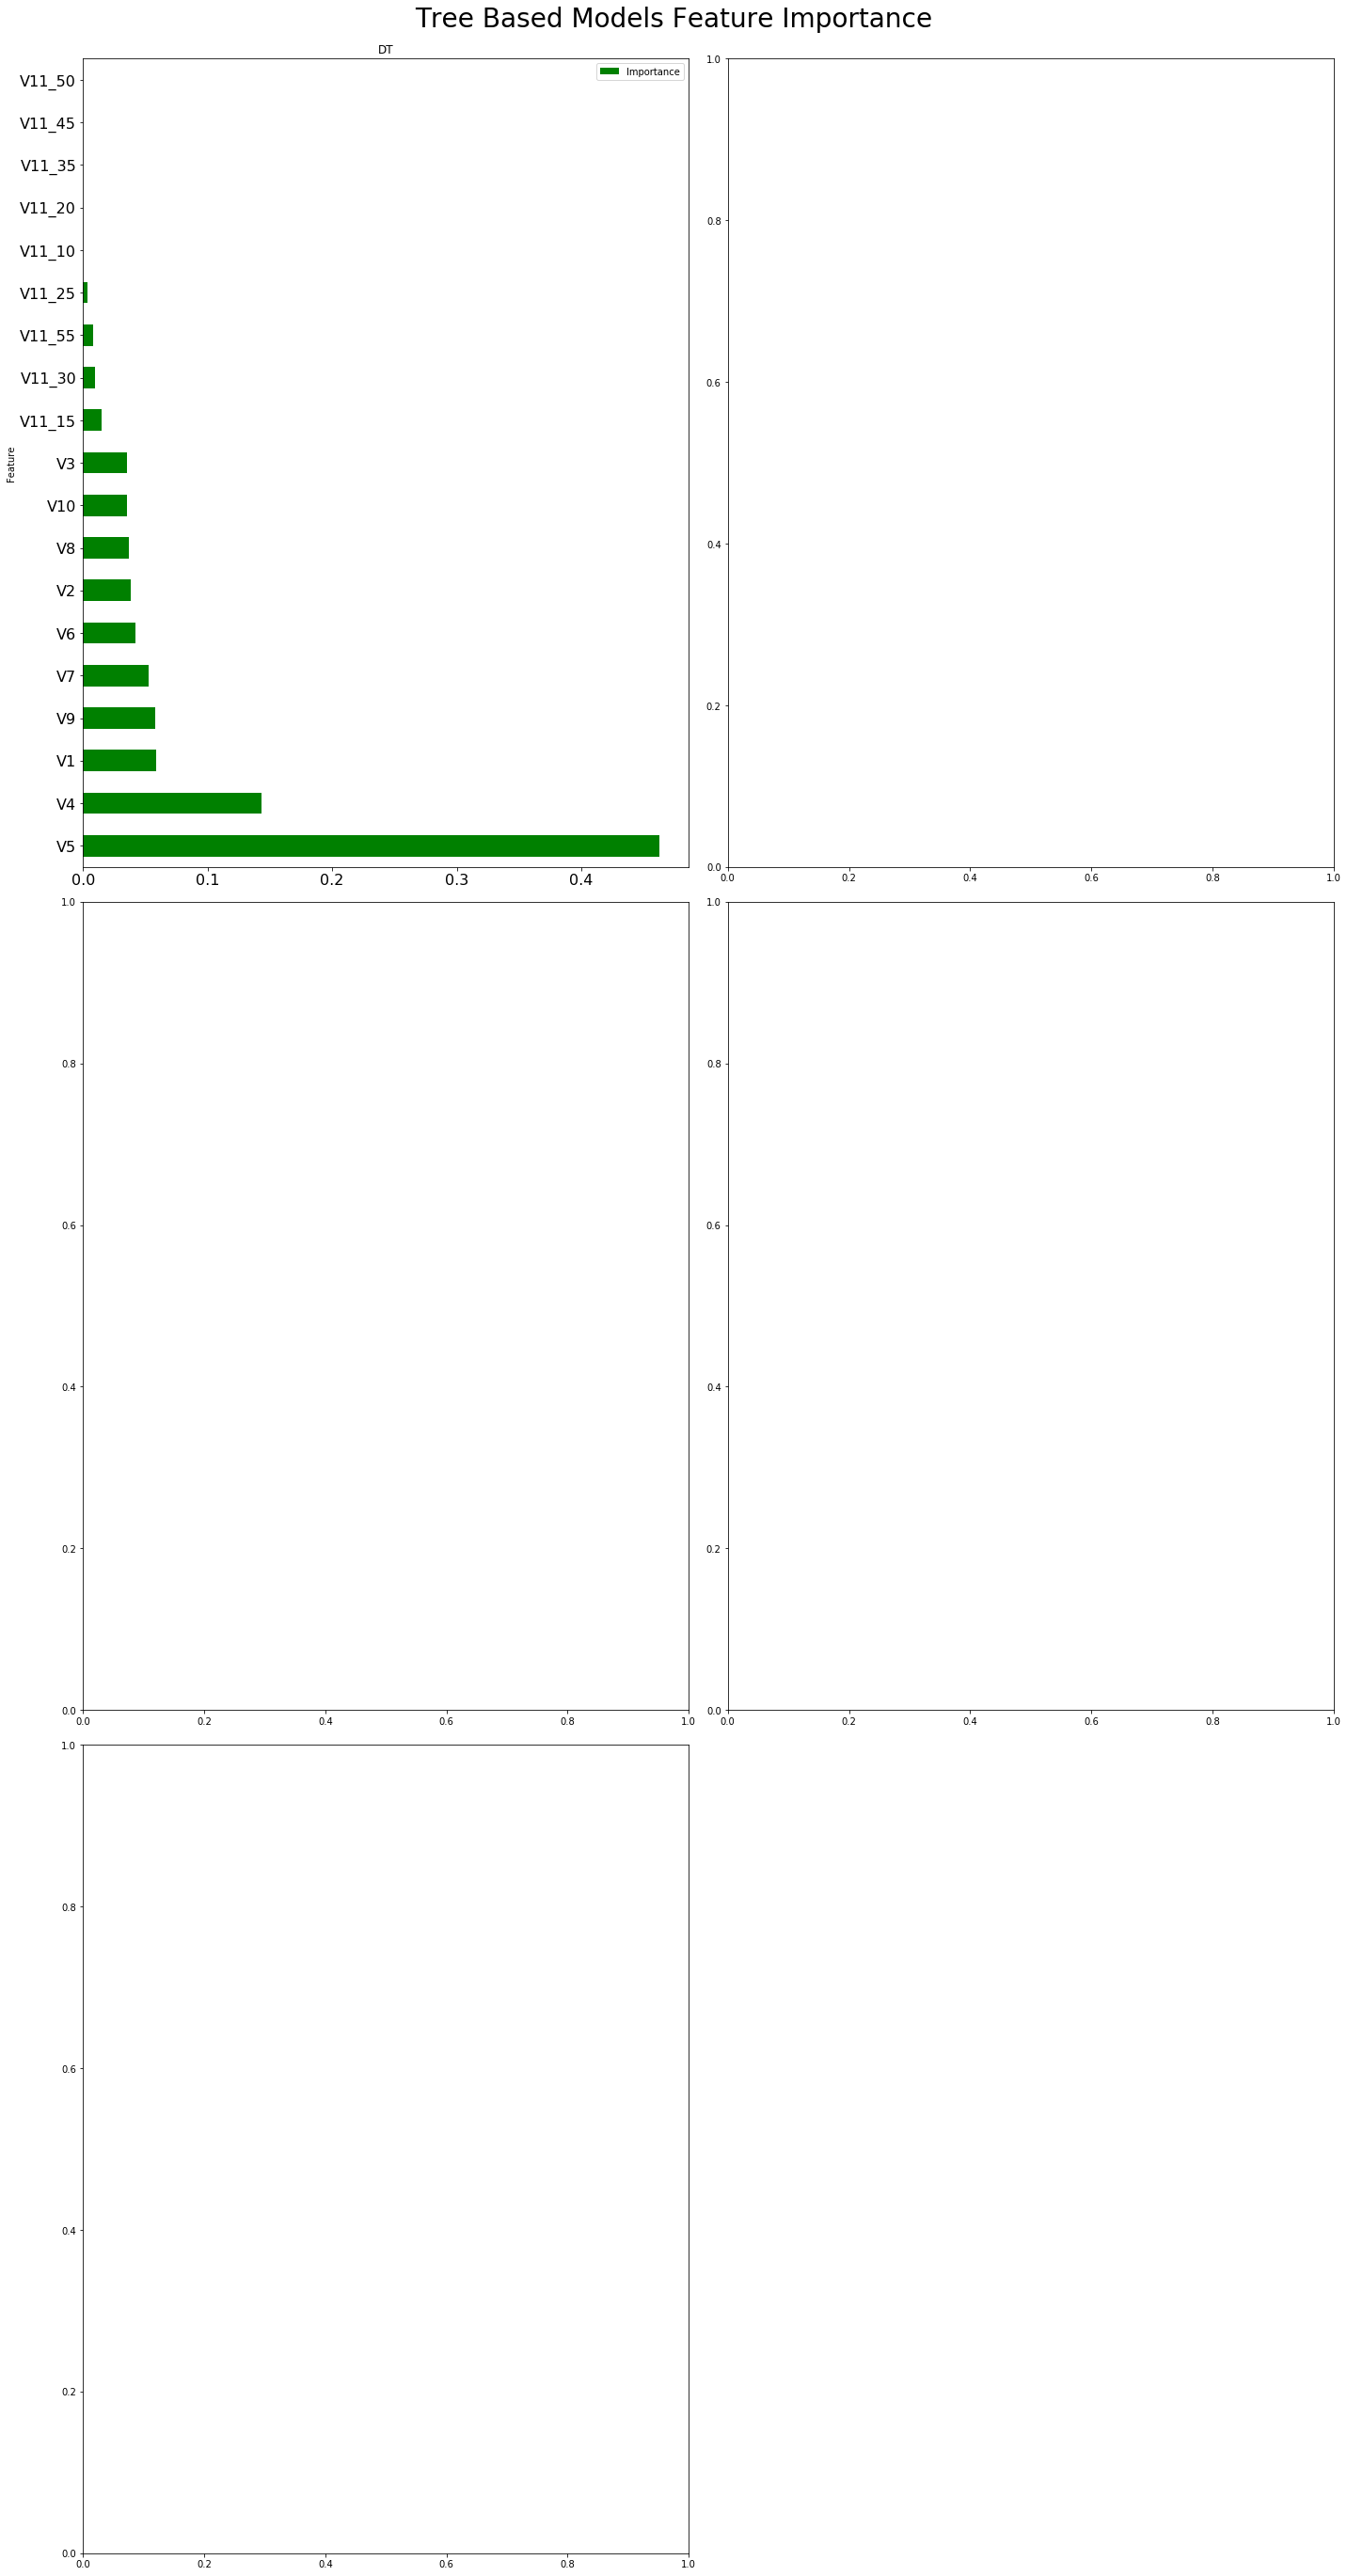

In [37]:
'''Create a function that plot feature importance by the selected tree based models.'''
def feature_importance(model):
    importance = pd.DataFrame({'Feature': X_train.columns,
                              'Importance': np.round(model.feature_importances_,3)})
    importance = importance.sort_values(by = 'Importance', ascending = False).set_index('Feature')
    return importance

'''Create subplots of feature impotance of rf, gbc, dt, etc, and abc.'''
fig, axes = plt.subplots(3,2, figsize = (20,40))
fig.suptitle('Tree Based Models Feature Importance', fontsize = 28)
tree_models = [dt]
tree_names = ['DT']

for ax, model, name in zip(axes.flatten(), tree_models, tree_names):
    feature_importance(model).plot.barh(ax = ax, title = name, fontsize = 16, color = 'green')
fig.delaxes(ax = axes[2,1]) # We don't need the last subplot.
fig.tight_layout(rect = [0, 0.03, 1, 0.97])